In [2]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import os
import shutil
import numpy as np

import cv2
from matplotlib import pyplot as plt

try:
    os.mkdir('dataset')
except: #if already exist - we wish to override
    shutil.rmtree('dataset')
    os.mkdir('dataset')

def save():
    global image_number, image1, draw
    filename = f'dataset/{image_number}.png'
    image1.save(filename)
    image_number += 1
    cv.delete("all")
    image1 = Image.new('RGB', (640, 480), 'white')
    draw = ImageDraw.Draw(image1)
    
def process():
    # please don't: cv.delete("all")
    cv.delete("all")

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y


def paint(e):
    global lastx, lasty
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), width=4)
    #  --- PIL
    draw.line((lastx, lasty, x, y), fill='black', width=4)
    lastx, lasty = x, y

def center_images():
    global image_number, image1, draw
    filename = f'dataset/{image_number}.png'
    image1.save(filename)
    for k in range(image_number+1):
        image = Image.open('dataset/'+str(k)+'.png')
        image = np.uint8(np.array(image))
        l = 0
        u = 0
        r = 640
        d = 480
        for i in range(480):
            if np.any(image[i,:,:] == 0):
                u = i
                break
        for i in range(u, 480):
            if np.all(image[i,:,:] == 255):
                d = i
                break
        for j in range(640):
            if np.any(image[:,j,:].all() == 0):
                l = j
                break
        for j in range(l, 640):
            if np.all(image[:,j,:] == 255):
                r = j
                break
        #print(l, u, r, d)
        image = image[u:d,l:r,:].copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (100, 60))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = Image.fromarray(image)
        image.save('dataset/'+str(k)+'.png')

root = Tk()
w = Label(root, text="Please draw several handwritting signatures to the database with"
          " 'save' button.\nwhen finished, sign again and type the 'process' button") 
w.pack() 
root.title('Handwritten signature veriﬁcation')
root.resizable(0, 0)


lastx, lasty = None, None
image_number = 0

cv = Canvas(root, width=640, height=480, bg='white')

# --- PIL
image1 = Image.new('RGB', (640, 480), 'white')
draw = ImageDraw.Draw(image1)

cv.bind('<1>', activate_paint)
cv.pack(expand=YES, fill=BOTH)

btn_save = Button(root, text="save", command=save)
btn_save.pack()
btn_save.place(x=250, y=480)

btn_process = Button(root, text="process", command=center_images)
btn_process.pack()
btn_process.place(x=320, y=480)

root.mainloop()

In [3]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from numpy import linalg as la

In [4]:
os.chdir('dataset')

In [5]:
 print(os.getcwd())

/home/matan/dataset


In [6]:
T = np.zeros((60*100, image_number - 1))
dirs = os.listdir()
k = 0
l = 0
for i in range(image_number):
    img = cv2.imread(str(i)+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if i < image_number - 1:
        T[:,k] = img.reshape(-1)
        k += 1
        i += 1
    else:
        test = img.reshape(-1)

#
example = T[:,2].copy()
#
    
T = np.float64(T)
Mean = np.mean(T, axis=1)
for i in range(image_number - 1):
    T[:,i] -= Mean
    

T is the matrix of preprocessed training examples,  
where each column contains one mean-subtracted image

In [7]:
test = test - Mean

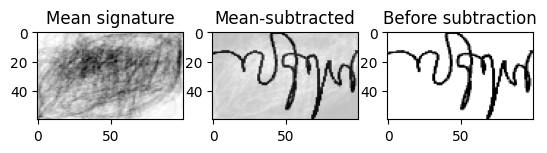

In [8]:
# only example
plt.subplot(131)
plt.imshow(Mean.reshape((60,100)), cmap = 'gray')
plt.title('Mean signature')
plt.subplot(132)
plt.imshow(T[:,2].reshape((60,100)), cmap = 'gray')
plt.title('Mean-subtracted')
plt.subplot(133)
plt.imshow(example.reshape((60,100)), cmap = 'gray')
plt.title('Before subtraction')
plt.show()

In [9]:
#  S is the covariance matrix
#S = T @ np.transpose(T)
#print (S.shape)

It's hard to compute eigenvectors of S,  
due to its dimensions. So there is a trick:

In [10]:
Temp = np.transpose(T) @ T

Now we find the eigenvectors of Temp,  
altought they aren't of the covariance matrix

In [11]:
eigval, eigvect = la.eigh(Temp)
print(eigval.shape)
print(eigvect.shape)

(100,)
(100, 100)


Thus, the covariance eigenvalues,  
also called eigenfaces : 

In [12]:
eigenfaces = np.dot(T, eigvect)
print (eigenfaces.shape)

(6000, 100)


Now, we do had to normelize those eigenvectors:  
each column is an eigenface / eigenvector

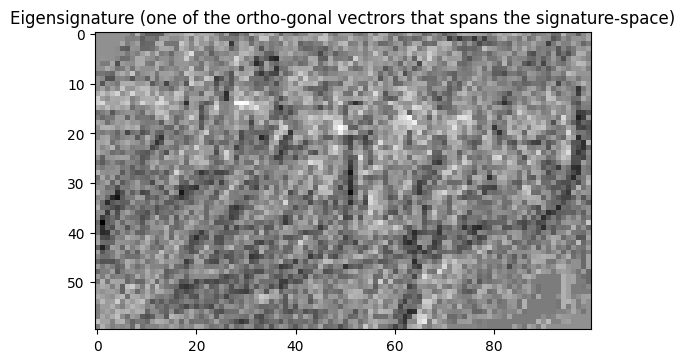

In [13]:
plt.imshow(eigenfaces[:,0].reshape((60,100)), cmap = 'gray')
plt.title('Eigensignature (one of the ortho-gonal vectrors that spans the signature-space)')
plt.show()

In [14]:
norms = la.norm(eigenfaces, axis=0)
# vector of all images' norms
print(norms.shape)

normeigenfaces = (1.0/norms)*eigenfaces
print(normeigenfaces.shape, eigenfaces.shape)

#normeigenfaces = (1.0/norms)*eigenfaces

(100,)
(6000, 100) (6000, 100)


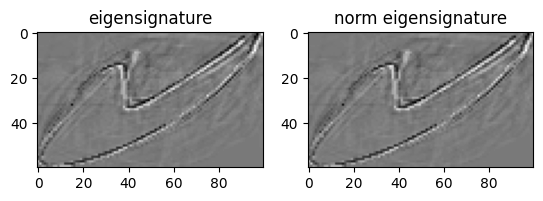

0.0 0.0


In [15]:
plt.subplot(121)
plt.imshow(eigenfaces[:,2].reshape((60,100)), cmap = 'gray')
plt.title('eigensignature')
plt.subplot(122)
plt.imshow(normeigenfaces[:,2].reshape((60,100)), cmap = 'gray')
plt.title('norm eigensignature')
plt.show()

print(eigenfaces[:,2].reshape((60,100))[0,0], normeigenfaces[:,2].reshape((60,100))[0,0])

In [16]:
eigenfaces = normeigenfaces

In [17]:
Tfeatures = np.dot(np.transpose(T), eigenfaces)
testfeature = np.dot(np.transpose(test), eigenfaces)

print (Tfeatures.shape, testfeature.shape)

(100, 100) (100,)


each image now has its own features vector,  
which is sort of an ID of the image

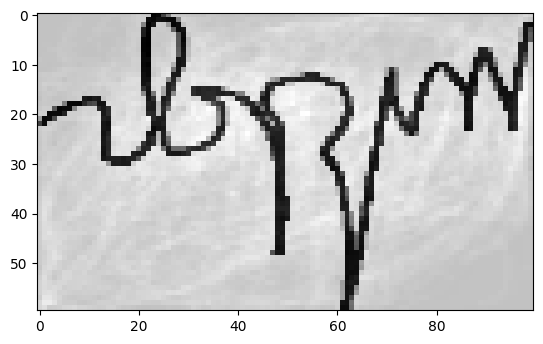

In [18]:
plt.imshow(test.reshape((60,100)), cmap = 'gray')
plt.show()

Now, let's find this face on the T matrix

In [19]:
#print(testfeature)
#print(Tfeatures[25])

In [20]:
min = la.norm(Tfeatures[0] - testfeature)
index = 0

for i in range(image_number-1):
    val = la.norm(Tfeatures[i] - testfeature)
    #print(i, " : ", val)
    if val < min:
        min = val
        index = i

In [21]:
print (index)

81


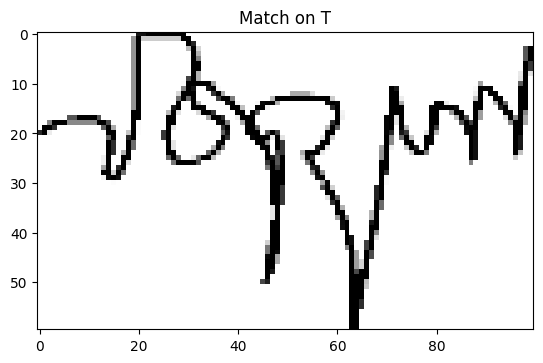

In [22]:
plt.imshow((T[:,index] + Mean).reshape((60,100)), cmap = 'gray')
plt.title('Match on T')
plt.show()